# Assignment 3 - Image Segmentation using MRFs

## GrabCut

---
**TA** : Rohan, Prajwal  
**Release date**: 05/03/21  
**Submission date** : 16/03/21

---

For this assignment you will implement the GrabCut method mentioned in this [paper](https://cvg.ethz.ch/teaching/cvl/2012/grabcut-siggraph04.pdf). It is essentially an iterative version of GraphCut as shown in the figure below. 
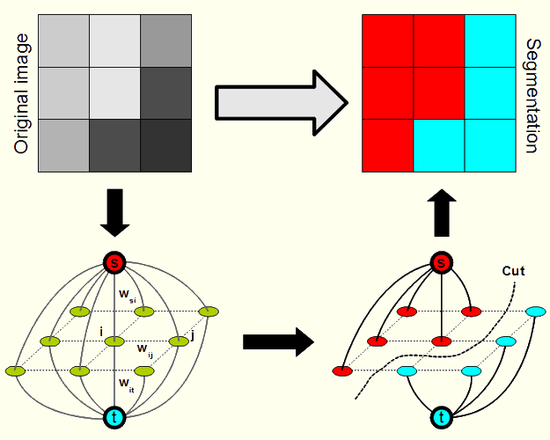

The code below takes an input image and follows these steps:
- It requires a bounding box to be drawn by the user to roughly segment out the foreground pixels
- It runs an initial min-cut optimization using the provided annotation
- The result of this optimization gives an initial segmentation 
- To further refine this segmentation, the user provides two kinds of strokes to aid the optimization
    - strokes on the background pixels
    - strokes on the foreground pixels
- The algorithm now utilizes this to refine the original segmentation

You are allowed to use standard GMM libraries for the implementation. For usage of other libraries, please contact the TAs.

You can view this [video](https://www.youtube.com/watch?v=aOqOwM-Qbtg) to get a better idea of the steps involved.

Image segmentation is one exciting application of MRFs. You can further read about other applications of MRFs for Computer Vision [here](https://cedar.buffalo.edu/~srihari/CSE574/Chap8/Ch8-PGM-Undirected/9.5-MRFinCV.pdf).

#### Useful Links
* https://courses.engr.illinois.edu/cs543/sp2011/lectures/Lecture%2012%20-%20MRFs%20and%20Graph%20Cut%20Segmentation%20-%20Vision_Spring2011.pdf

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn import mixture
import igraph as ig

In [45]:
class EventHandler:
    """
    Class for handling user input during segmentation iterations 
    """
    
    def __init__(self, flags, img, _mask, colors):
        
        self.FLAGS = flags
        self.ix = -1
        self.iy = -1
        self.img = img
        self.img2 = self.img.copy()
        self._mask = _mask
        self.COLORS = colors

    @property
    def image(self):
        return self.img
    
    @image.setter
    def image(self, img):
        self.img = img
        
    @property
    def mask(self):
        return self._mask
    
    @mask.setter
    def mask(self, _mask):
        self._mask = _mask
    
    @property
    def flags(self):
        return self.FLAGS 
    
    @flags.setter
    def flags(self, flags):
        self.FLAGS = flags
    
    def handler(self, event, x, y, flags, param):

        # Draw the rectangle first
        if event == cv2.EVENT_LBUTTONDOWN:
            if self.FLAGS['rect_over'] == False:
                self.FLAGS['DRAW_RECT'] = True
                self.ix, self.iy = x,y

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_RECT'] == True:
                self.img = self.img2.copy()
                cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
                self.FLAGS['rect_or_mask'] = 0

        elif event == cv2.EVENT_LBUTTONUP:
            if self.FLAGS['rect_over'] == False:
                self.FLAGS['DRAW_RECT'] = False
                self.FLAGS['rect_over'] = True
                cv2.rectangle(self._mask, (self.ix, self.iy), (x, y), self.COLORS['RED'], 2)
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(x), abs(y))
                self.FLAGS['rect_or_mask'] = 0

        
        # Draw strokes for refinement 

        if event == cv2.EVENT_LBUTTONDOWN:
            if self.FLAGS['rect_over'] == False:
                print('Draw the rectangle first.')
            else:
                self.FLAGS['DRAW_STROKE'] = True
                cv2.circle(self.img, (x,y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x,y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_STROKE'] == True:
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_LBUTTONUP:
            if self.FLAGS['DRAW_STROKE'] == True:
                self.FLAGS['DRAW_STROKE'] = False
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

In [8]:
class Grabcut1:
    def __init__(self,mask,img,gmm_components,gamma):
        self.mask = mask
        self.img = img
        self.gamma = gamma
        self.gmm_components = gmm_components
        self.edges = []
        self.edges_weights = []
        
        
        
    def fit_guassian(self,gmm_components,ite=100):
        my_guass = mixture.GaussianMixture(n_components=gmm_components,max_iter = ite,covariance_type='full')
        self.model_fg = my_guass.fit(self.img[np.where((self.mask==2) | (self.mask==3))])
        my_guass1 = mixture.GaussianMixture(n_components=gmm_components,max_iter = ite,covariance_type='full')
        self.model_bg = my_guass1.fit(self.img[np.where((self.mask==0) | (self.mask==1))])
        
        
    def find_u(self,my_img,my_model,indi):
        
        gmm_per_pixel = my_model.predict(my_img[indi]) # GMM component assigned to each pixel
        covs = my_model.covariances_[gmm_per_pixel] # Covariance (n_pixels x 3 x 3)
        pixel_vals = my_img[indi] # Values of the required pixels
        means = my_model.means_[gmm_per_pixel] # Means (n_pixels x 3)
        d_val = (-np.log(my_model.weights_[gmm_per_pixel])) + (0.5*np.log(np.linalg.det(covs)))
        mean_sub = pixel_vals - means
        cov_inv = np.linalg.pinv(covs)
        #add_term = 0.5*()
        temp = np.einsum('ik,ikj->ij',mean_sub,cov_inv)
        add_term = 0.5*np.einsum('ij,ij->i',temp,mean_sub)
        d_val = d_val + add_term
        
        return d_val
        
    def find_v(self):
        
        rows = self.img.shape[0]
        cols = self.img.shape[1]
        aa = np.sum(np.square(self.img[:, 1:] - self.img[:, :-1]))
        bb = np.sum(np.square(self.img[1:,:] - self.img[:-1,:]))
        left_part = self.img[:, 1:] - self.img[:, :-1]
        up_part =  self.img[1:,:] - self.img[:-1,:]
        #self.beta = np.sum(np.square(left_part)) +np.sum(np.square(up_part))
        #self.beta = aa + bb
        cc = aa + bb
        self.beta = 1 / (2 * cc / (2 * rows * cols))
        temp = np.sum(np.square(left_part), axis=2)
        self.V_left = self.gamma * np.exp(-self.beta * temp)
        temp = np.sum(np.square(up_part), axis=2)
        self.V_up = self.gamma * np.exp(-self.beta * temp)
        img_ind = np.arange(rows * cols,dtype=np.uint32).reshape(rows,cols)
        
        return img_ind
    
    def make_graph(self,edges,weights):
        notsure_indi = np.where((self.mask==1) | (self.mask==2))
        bg_indi = np.where((self.mask.reshape(-1)==0))
        fg_indi = np.where((self.mask.reshape(-1)==3))
        my_img = self.img
        prob_fg = self.find_u(my_img,self.model_fg, notsure_indi)
        prob_bg = self.find_u(my_img,self.model_bg, notsure_indi)
        
        notsure_indi = np.where((self.mask.reshape(-1)==1) | (self.mask.reshape(-1)==2))
        
        bg_terminal = self.img.shape[0] * self.img.shape[1] + 1
        fg_terminal = self.img.shape[0] * self.img.shape[1]
        
        ###
        edges.extend(list(zip([bg_terminal]*notsure_indi[0].shape[0],notsure_indi[0]))) # For foreground
        weights.extend(prob_fg)
        
        edges.extend(list(zip([fg_terminal]*notsure_indi[0].shape[0],notsure_indi[0]))) # For foreground
        weights.extend(prob_bg)
        
        edges.extend(list(zip([bg_terminal]*bg_indi[0].shape[0],bg_indi[0]))) # For background terminal
        weights.extend([np.inf]*bg_indi[0].shape[0])
        
        edges.extend(list(zip([fg_terminal]*fg_indi[0].shape[0],fg_indi[0]))) # For foreground terminal
        weights.extend([np.inf]*fg_indi[0].shape[0])
        
        return edges,weights
    
    def do_mincut(self,edges,weights):
        bg_terminal = self.img.shape[0] * self.img.shape[1] + 1
        fg_terminal = self.img.shape[0] * self.img.shape[1]
        
        #m1,m2,m3,m4 = self.find_v()
        img_ind =  self.find_v()
    
        edges.extend(list(zip(img_ind[:, 1:].reshape(-1), img_ind[:, :-1].reshape(-1))))
        weights.extend(self.V_left.reshape(-1).tolist())
        edges.extend(list(zip(img_ind[1:, :].reshape(-1), img_ind[:-1, :].reshape(-1))))
        weights.extend(self.V_up.reshape(-1))
                        
        self.my_graph = ig.Graph(self.img.shape[0] * self.img.shape[1]+ 2)
        self.my_graph.add_edges(np.array(edges))
        
        mincut = self.my_graph.st_mincut(fg_terminal, bg_terminal, weights)
        pr_indexes = np.where((self.mask == 2))           
        img_indexes = np.arange(self.img.shape[0] * self.img.shape[1],dtype=np.uint32).reshape(self.img.shape[0], self.img.shape[1])
        self.mask[pr_indexes] = np.where(np.isin(img_indexes[pr_indexes], mincut.partition[0]), 2, 1)
        
    def run(self,ite=1):
        edges = []
        weights = []
        gmm_components = self.gmm_components 
        self.fit_guassian(gmm_components,ite)
        edges,weights = self.make_graph(edges,weights)
        self.do_mincut(edges,weights)
        #print("Mask using at iteration " + str(aa))
        plt.title("Mask after segmentation")
        plt.imshow(self.mask,cmap="gray")
        plt.show()
        return self.img,self.mask

In [9]:
def run1(filename: str,gmm_components=5,gamma=50,gm_ite=100):
    """
    Main loop that implements GrabCut. 
    
    Input
    -----
    filename (str) : Path to image
    """
    
    COLORS = {
    'BLACK' : [0,0,0],
    'RED'   : [0, 0, 255],
    'GREEN' : [0, 255, 0],
    'BLUE'  : [255, 0, 0],
    'WHITE' : [255,255,255]
    }

    DRAW_BG = {'color' : COLORS['BLACK'], 'val' : 5}
    DRAW_FG = {'color' : COLORS['WHITE'], 'val' : 3}
    

    FLAGS = {
        'RECT' : (0, 0, 1, 1),
        'DRAW_STROKE': False,         # flag for drawing strokes
        'DRAW_RECT' : False,          # flag for drawing rectangle
        'rect_over' : False,          # flag to check if rectangle is  drawn
        'rect_or_mask' : -1,          # flag for selecting rectangle or stroke mode
        'value' : DRAW_FG,            # drawing strokes initialized to mark foreground
    }

    img = cv2.imread(filename)
    img2 = img.copy()
    mask = np.zeros(img.shape[:2], dtype = np.uint8) # mask is a binary array with : 0 - background pixels                                                 #                               1 - foreground pixels 
    output = np.zeros(img.shape, np.uint8)           # output image to be shown

    # Input and segmentation windows
    cv2.namedWindow('Input Image')
    cv2.namedWindow('Segmented output')
    
    EventObj = EventHandler(FLAGS, img, mask, COLORS)
    cv2.setMouseCallback('Input Image', EventObj.handler)
    cv2.moveWindow('Input Image', img.shape[1] + 10, 90)
    my_counter = 0
    while(1):
        
        img = EventObj.image
        mask = EventObj.mask
        FLAGS = EventObj.flags
        cv2.imshow('Segmented image', output)
        cv2.imshow('Input Image', img)
        
        k = cv2.waitKey(1)

        # key bindings
        if k == 27:
            # esc to exit
            break
        
        elif k == ord('0'): 
            # Strokes for background
            FLAGS['value'] = DRAW_BG
        
        elif k == ord('1'):
            # FG drawing
            FLAGS['value'] = DRAW_FG
        
        elif k == ord('r'):
            # reset everything
            FLAGS['RECT'] = (0, 0, 1, 1)
            FLAGS['DRAW_STROKE'] = False
            FLAGS['DRAW_RECT'] = False
            FLAGS['rect_or_mask'] = -1
            FLAGS['rect_over'] = False
            FLAGS['value'] = DRAW_FG
            img = img2.copy()
            mask = np.zeros(img.shape[:2], dtype = np.uint8) 
            EventObj.image = img
            EventObj.mask = mask
            output = np.zeros(img.shape, np.uint8)
            my_counter = 0
        
        elif k == 13:
            my_counter = my_counter + 1
            rect_ = FLAGS['RECT']
            pakka_fg = np.where((mask==3))
            pakka_bg = np.where((mask==5))
            maybe_bg = np.where((mask==1))
            maybe_fg = np.where((mask==2))
            mask[rect_[1]:rect_[3],rect_[0]:rect_[2]] = 2
            mask[pakka_fg] = 3
            mask[pakka_bg] = 0
            mask[maybe_fg] = 2
            mask[maybe_bg] = 1
            print("Running iteration number - " + str(my_counter))
            plt.title("Initial Mask")
            plt.imshow(mask,cmap="gray")
            plt.show()
            gb = Grabcut1(mask,img2,gmm_components,gamma)
            my_img, my_mask = gb.run(gm_ite)
            EventObj.mask = my_mask
            my_img[(my_mask == 0) | (my_mask == 1)] = (0,0,0) 
            my_img = cv2.cvtColor(my_img, cv2.COLOR_BGR2RGB)
            plt.title("Segmented image foreground")
            plt.imshow(my_img)
            plt.show()
            FLAGS['rect_or_mask'] = 1
                
        EventObj.flags = FLAGS
        mask2 = np.where((mask == 2) + (mask == 3), 255, 0).astype('uint8')
        output = cv2.bitwise_and(img2, img2, mask = mask2)

# Few Examples

Draw the rectangle first.
Running iteration number - 1


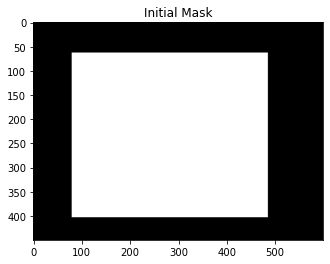

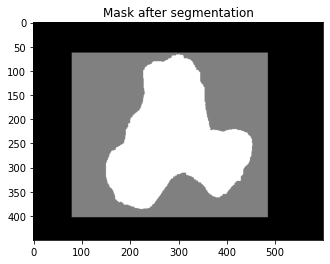

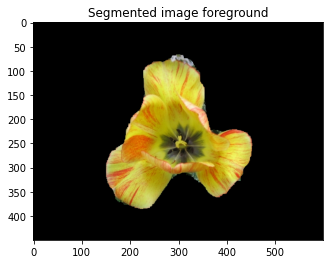

In [46]:
filename = '../images/flower.jpg'               # Path to image file
run1(filename,gmm_components=5,gamma=50,gm_ite=100)
cv2.destroyAllWindows()

Draw the rectangle first.
Running iteration number - 1


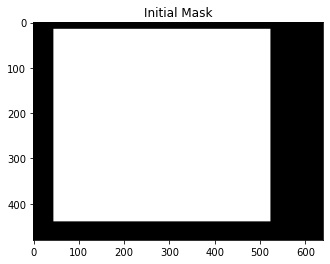

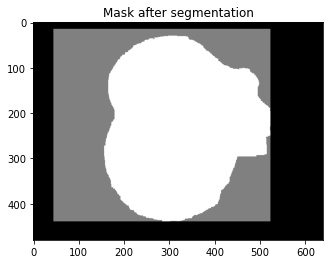

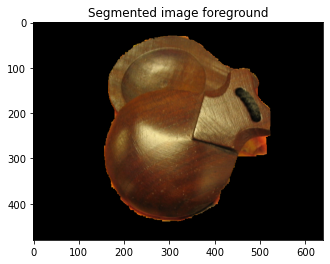

In [20]:
filename = '../images/music.jpg'               # Path to image file
run1(filename,gmm_components=5,gamma=50,gm_ite=100)
cv2.destroyAllWindows()

Draw the rectangle first.
Running iteration number - 1


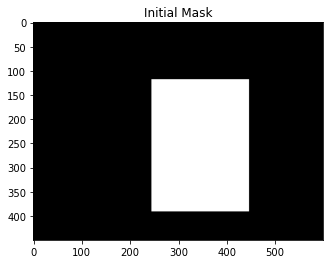

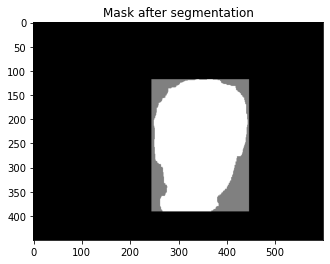

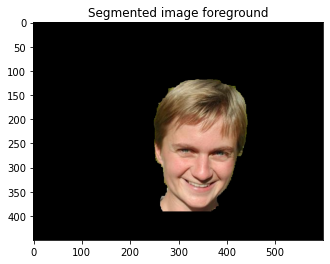

In [62]:
filename = '../images/person2.jpg'               # Path to image file
run1(filename,gmm_components=5,gamma=50,gm_ite=100)
cv2.destroyAllWindows()

Draw the rectangle first.
Running iteration number - 1


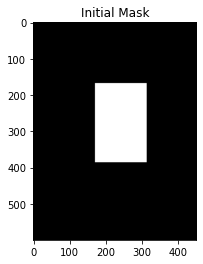

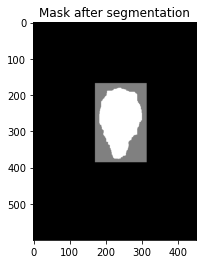

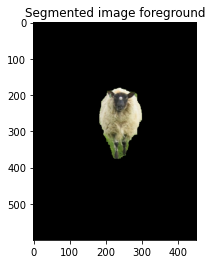

In [69]:
filename = '../images/sheep.jpg'              # Path to image file
run1(filename,gmm_components=5,gamma=100,gm_ite=1000)
cv2.destroyAllWindows()

Draw the rectangle first.
Running iteration number - 1


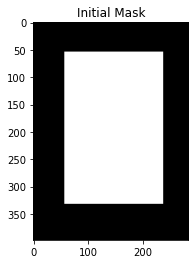

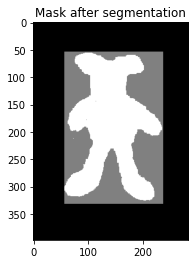

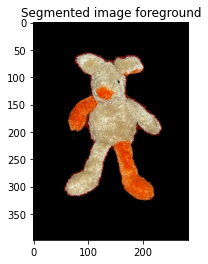

In [70]:
filename = '../images/teddy.jpg'               # Path to image file
run1(filename,gmm_components=5,gamma=50,gm_ite=100)
cv2.destroyAllWindows()

Draw the rectangle first.
Running iteration number - 1


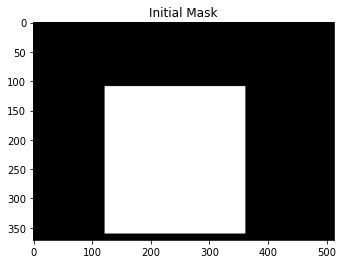

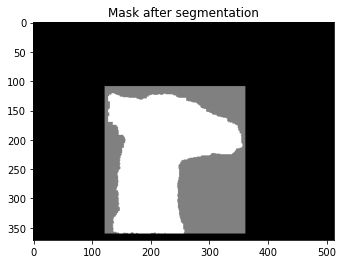

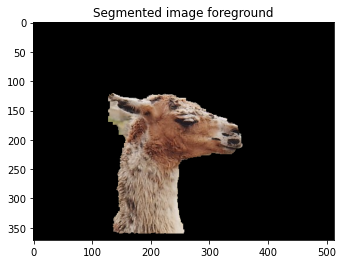

In [71]:
filename = '../images/llama.jpg'               # Path to image file
run1(filename,gmm_components=5,gamma=50,gm_ite=100)
cv2.destroyAllWindows()

# Observations

## With Scribbling

Draw the rectangle first.
Running iteration number - 1


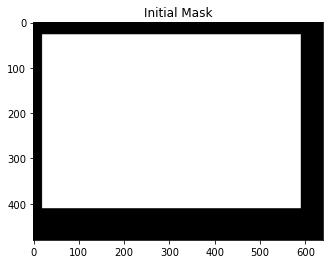

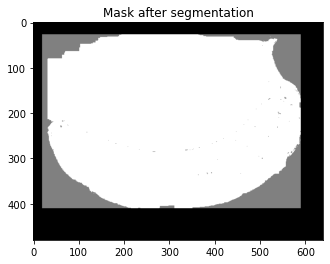

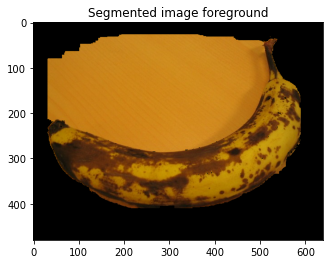

Running iteration number - 2


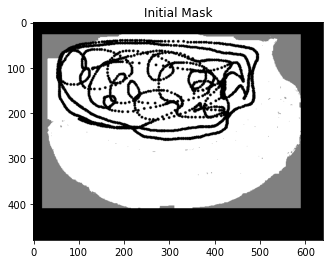

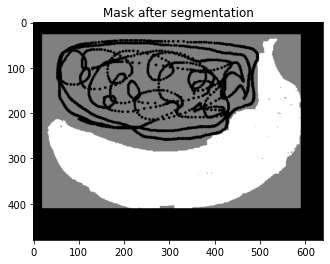

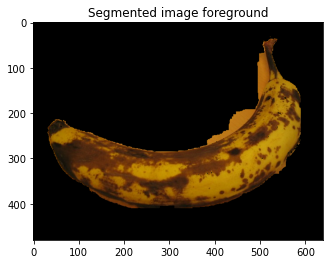

Running iteration number - 3


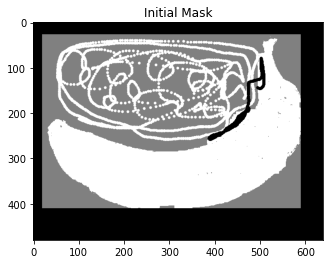

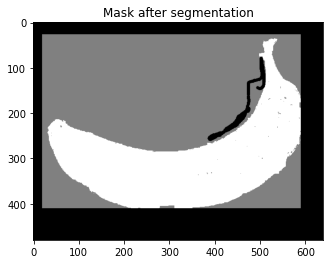

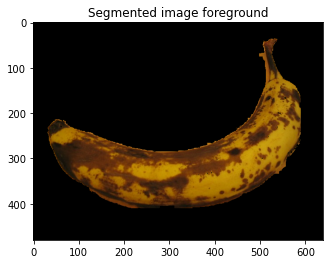

In [19]:
if __name__ == '__main__':
    filename = '../images/banana1.jpg'               # Path to image file
    run1(filename,gmm_components=5,gamma=50,gm_ite=100)
    cv2.destroyAllWindows()

In [ ]:

filename = '../images/banana1.jpg'               # Path to image file
run1(filename,gmm_components=5,gamma=50,gm_ite=100)
cv2.destroyAllWindows()

## The number of mixture components in GMM

 Since most images have continuous patches of colors, we can train a GMM with multiple multivariate gaussian components to fit the color space of a given image. The more the variation we need more guassians to fit for the model. 
 
 To demostrate it I took the example of doll.jpg image. It has multiple color patches which is perfrectly suitable for this example.
 
 We can clearly see that the segmented image is missing many components( like eyes) when we use GMM_comp = 1
 and when we use gmm_comp = 5 there is better improvement but still few things couldn't fit properly. At gmm_comp = 10 it could fit many so the output is better than previous two.
 
 Wecan say that mixture components are useful for better modelling 

### gmm_components = 1

Draw the rectangle first.
Running iteration number - 1


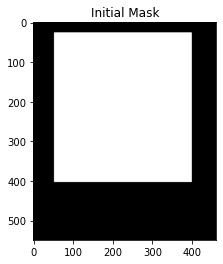

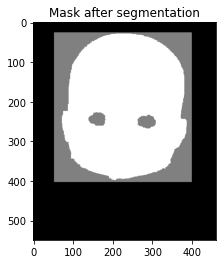

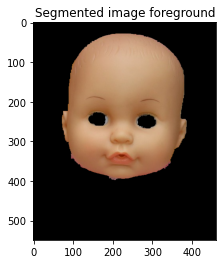

In [48]:
filename = '../images/doll.jpg'               # Path to image file
run1(filename,gmm_components=1,gamma=50,gm_ite=100)
cv2.destroyAllWindows()

### gmm_components = 5

Draw the rectangle first.
Running iteration number - 1


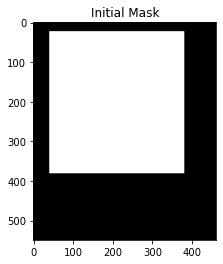

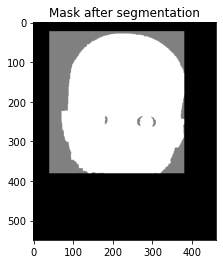

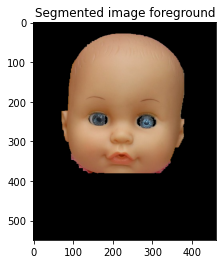

In [31]:
filename = '../images/doll.jpg'               # Path to image file
run1(filename,gmm_components=5,gamma=50,gm_ite=100)
cv2.destroyAllWindows()

### gmm_components = 10

Draw the rectangle first.
Running iteration number - 1


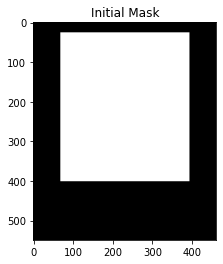

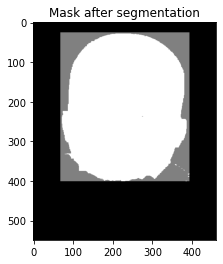

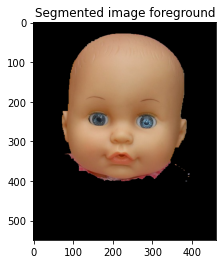

In [50]:
filename = '../images/doll.jpg'               # Path to image file
run1(filename,gmm_components=10,gamma=50,gm_ite=100)
cv2.destroyAllWindows()

## The choice of Gamma

Gamma is useful for better seperation between the FG and BG. The higher the gamma, more stricter will be the differentiation.

Here using Banana example we can claerly observe with gamma=50 there's no better segmentation because the BG is similar to FG and tough to identify the variations. But with higher gamma we can have better differentiation in the image. 

### Example 1 : Banana

### Smaller gamma = 50

Draw the rectangle first.
Running iteration number - 1


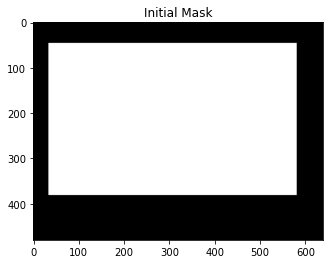

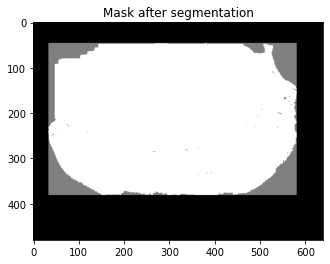

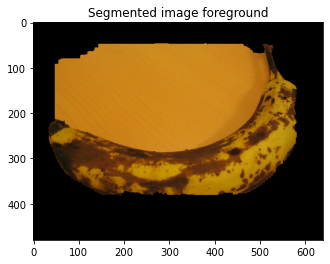

In [38]:
filename = '../images/banana1.jpg'               # Path to image file
run1(filename,gmm_components=5,gamma=50,gm_ite=100)
cv2.destroyAllWindows()

### Higher gamma (5000)

Draw the rectangle first.
Running iteration number - 1


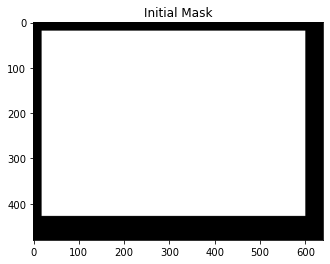

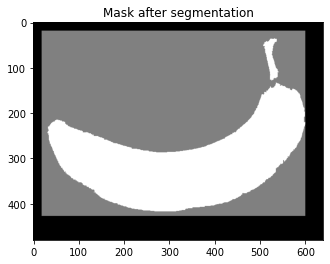

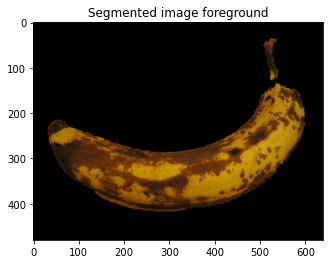

In [40]:
filename = '../images/banana1.jpg'               # Path to image file
run1(filename,gmm_components=5,gamma=5000,gm_ite=100)
cv2.destroyAllWindows()

### Example 2

### smaller gamma (50)

Draw the rectangle first.
Running iteration number - 1


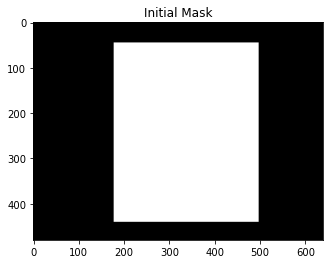

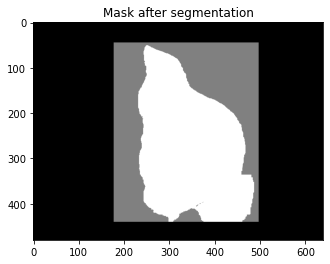

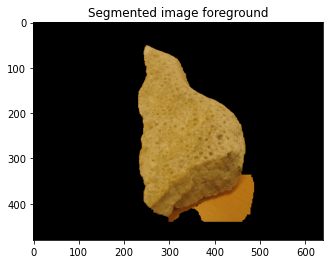

In [51]:
filename = '../images/stone1.jpg'               # Path to image file
run1(filename,gmm_components=5,gamma=50,gm_ite=100)
cv2.destroyAllWindows()

### Higher Gamma (200) 

Draw the rectangle first.
Running iteration number - 1


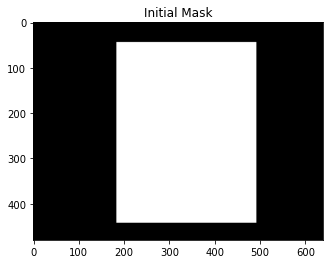

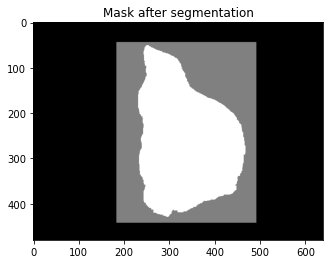

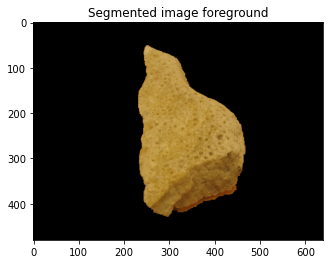

In [52]:
filename = '../images/stone1.jpg'               # Path to image file
run1(filename,gmm_components=5,gamma=200,gm_ite=100)
cv2.destroyAllWindows()

## Effects of Bounding Box

### Tight bound box 

Draw the rectangle first.
Running iteration number - 1


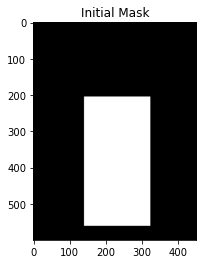

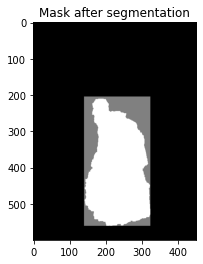

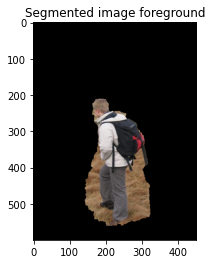

In [60]:
filename = '../images/person3.jpg'               # Path to image file
run1(filename,gmm_components=5,gamma=50,gm_ite=100)
cv2.destroyAllWindows()

### Loose bound box 

Draw the rectangle first.
Running iteration number - 1


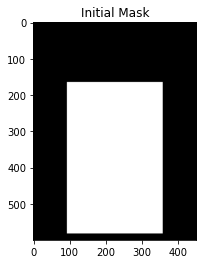

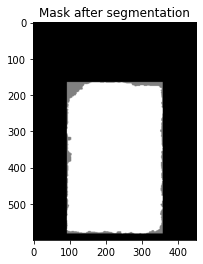

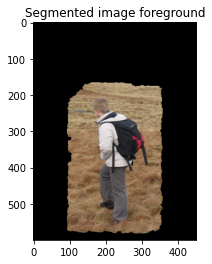

In [61]:
filename = '../images/person3.jpg'               # Path to image file
run1(filename,gmm_components=5,gamma=50,gm_ite=100)
cv2.destroyAllWindows()

## Iterations of GMM

Draw the rectangle first.
Draw the rectangle first.
Running iteration number - 1


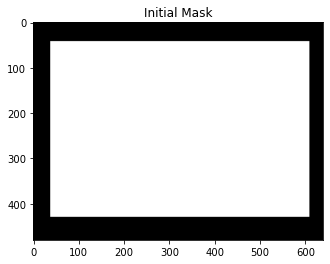

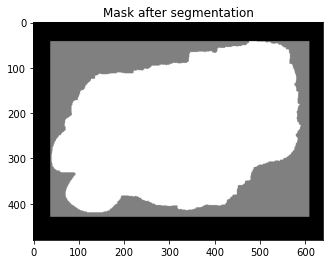

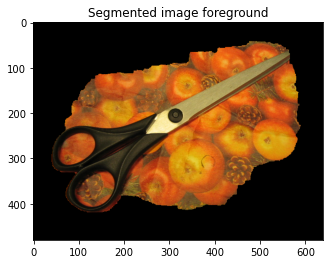

In [67]:
filename = '../images/scissors.jpg'              # Path to image file
run1(filename,gmm_components=5,gamma=100,gm_ite=1000)
cv2.destroyAllWindows()